In [2]:
pip install PyMieScatt

  Created wheel for PyMieScatt: filename=PyMieScatt-1.8.1.1-cp37-none-any.whl size=14960 sha256=843a0ebbc990b2446f2c585894b0116aaf2eb52a7e1b45e9246dc8a5541db4ba
  Stored in directory: /root/.cache/pip/wheels/a2/5a/1f/3be6174331b4a5fe7e5b1ef1327a461d80804c2f23515fcdeb
Successfully built PyMieScatt


In [3]:
import PyMieScatt as ps
import numpy as np
from PyMieScatt.Mie import Mie_ab
import matplotlib.pyplot as plt
from matplotlib.contour import QuadContourSet
from matplotlib.collections import LineCollection
from scipy.ndimage import zoom
from scipy.integrate import trapz
from shapely import geometry
from mpl_toolkits.mplot3d import axes3d  # Fonction pour la 3D
from numpy import linalg as npl
import scipy.linalg as spl

### Distributions 
We define two types of distributions and we try to retrieve them by using this algorithm

In [4]:
def lognormal(d,sigma):
    d_size = len(d)
    #print(d_size)
    d_mean = (1/d_size)*sum(d)
    q = np.zeros(d_size)
    l = -(np.log(d)+np.log(d_mean))**2/2*sigma**2
    for i in range(d_size):
        q[i] = (1/(np.sqrt(2*np.pi)*d[i]*sigma))*np.exp(-(np.log(d[i])-np.log(d_mean))**2/(2*sigma**2))
    return q


def normal(a, sigma):
  #a*=1e3
  a0=(a[0]+a[-1])/2
  return (1/np.sqrt(2*np.pi*sigma))*np.exp(-1*(a-a0)**2/(sigma**2))



### Function to calculate an SVD of a matrix 

In [5]:
def SVD(A):
    # Arguments en entrée:
    # A : la matrice dont on veut la décomposition
    # Arguments en sortie:
    # U,S,V : U et V étant les matrices orthogonales
    # des vecteurs singuliers à gauche/droite et S
    # est une matrice de même taille que A dont la 
    # diagonale consistuée des valeurs singulières
    # par ordre décroissant
    
    n,m = np.shape(A)
    D,V = spl.eigh(A.T.dot(A))
    idD = np.argsort(np.real(abs(D)))[::-1]
    V = V[:,idD]
    D = np.real(abs(D[idD]))
    s = np.real(D)
    s = np.sqrt(s[s>0])
    r = len(s)
    V = V[:,0:r]
    U = np.zeros((n,r))
    for k in range(r):
        U[:,k] = 1./s[k]*A.dot(V[:,k])
    S = np.zeros((r,r))
    for k in range(r):
        S[k,k] = s[k]
    return U,np.diag(S),V

### Calcul of intensity $K(\lambda, a)$

$K(\lambda, a) =\frac{i_{1}+i_{2}}{8 \pi^{2} r^{2}} \lambda^{2}$



In [6]:
def inten(w, n, k, d, theta,r=1e6):  #r=1m ? 
    d*=1e3     #??
    S1,S2=ps.MieS1S2(n+(1j*k),np.pi*d/w,np.cos(theta))
    SL=np.abs(S1)**2
    SR=np.abs(S2)**2
    return w**2*(SL**2+SR**2)/(8*(np.pi*r)**2)


### Discretisation of the L and A operators 

$L [f(a)]=\int_{0}^{\infty} K(\lambda, a) f(a) \mathrm{d} a$ 

$A=L^*L$

The objective is to compute the eigen values $\alpha_k$ and eigenvectors $u_k$ of the matrix $A$.

For this we calculate the operator L, represented by a matrix composed by elements $\left(L(\lambda_j,a_i)\right)_{1\leq j \leq M, 1\leq i \leq N}$ 


In [7]:
#Premier code de l'opérateur

def L_op(d, w, sigma,n,k,theta):
  q=normal(d,sigma)
  N=len(d)
  M=len(w)
  moy=(d[-1]+d[0])/2
  L=np.zeros((N,M))
  for i in range(N):
    for j in range(M):
      L[i,j]=inten(w[j],n,k,d[i],theta)*q[i]
  return L


#Calcul of A
def Oper(L):
    #N=len(L)
    #A=np.zeros((N,N))
    #L=np.reshape(L,(N,1))
    A=L@L.T
    return A
  

### Finding the f distribution with regularization term $\mu$
$f_{\mu}\left(a_{i}\right)=\sum_{k=1}^{N}\left[\alpha_{k}\left(\alpha_{k}^{2}+\mu\right)^{-1} \sum_{j=1}^{M} w_{k} g\left(\lambda_{j}\right) v_{k}\left(\lambda_{j}\right)\right] u_{k}\left(a_{i}\right)$

In [8]:
def f_mu(v, alp, u, d, w, sigma, theta, n, ki,mu,i):
  N=len(d)
  M=len(w)
  Q=normal(d,sigma)
  fmu=[]
    #calcul of the sum
  for k in range(N):
    pr=u[k][i]*alp[k]/(alp[k]**(2)+mu)
    fint=0
    for j in range(M):
      fint+=inten(w[j], n, k, Q[i], theta)*v[k][j]  
      fmu.append(fint*pr)
  return sum(fmu)

### Parameters

In [9]:
n=1.33
k=0
N=60
d=np.linspace(0.1,2,N)
w=np.linspace(400,800,N)
moy=(d[0]+d[-1])/2
sigma=0.2
theta=np.linspace(4.95,5.05,5)
Norm=normal(d, sigma)
delta=len(theta)
mu=np.exp(-45)

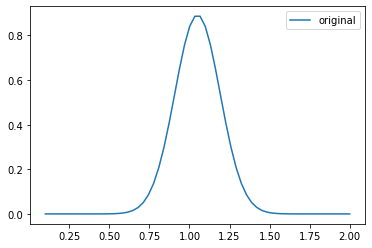

theta= 4.95


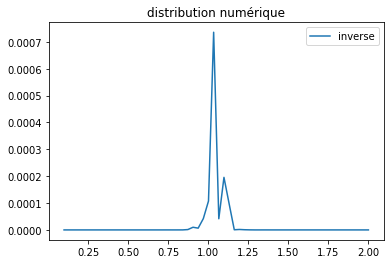

theta= 4.975


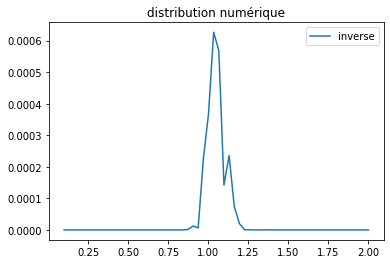

theta= 5.0


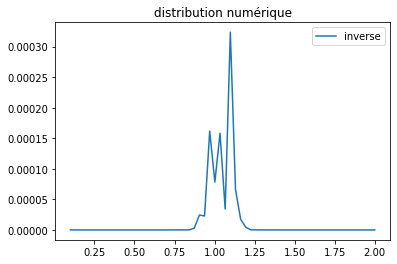

theta= 5.025


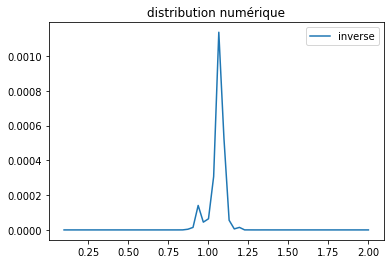

theta= 5.05


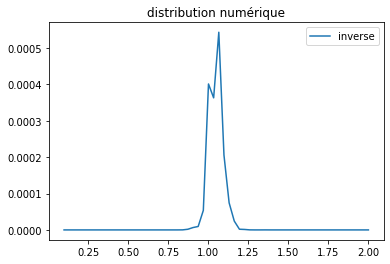

In [17]:
#plot of the real solution 
plt.plot(d,Norm,label="original")
plt.legend()
plt.show()
distrib=np.zeros(N)
moy=[] #to calculate an average on a delta theta
I=np.eye(N)
for q in range(delta): #calcul for different theta 
  Lt=L_op(d, w, sigma,n,k,theta[q])
  Lt=Lt*1e15 #normalization ??

  vg,S,u=SVD(Lt) #calcul of the SVD to call f_mu 
  #At=Oper(Lt)
  #S,vg=npl.eig(At)
  
  for i in range(N): #calcul of the solution according to several diameters 
    distrib[i]=np.abs(f_mu(vg, S, u,d, w, sigma, mu, n, k,theta[q],i))#max(f_mu(vg, S, u,d, w, sigma, mu, n, k,theta[q],i),0)#max(f_mu(vg, S, u,d, w, sigma, mu, n, k,theta,i),0)
  moy.append(distrib)
  print("theta=", theta[q])
  plt.plot(d,distrib,label="inverse")
  plt.legend()
  plt.title("distribution numérique")
  plt.show()


### Plot of the average of the results for a $\Delta \theta$ 

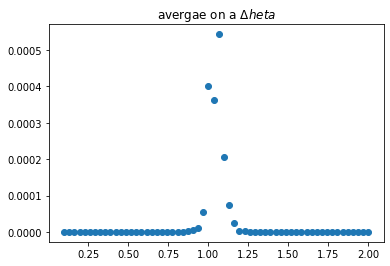

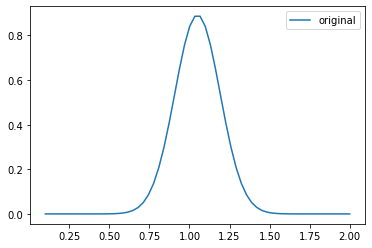

In [18]:
MOY=np.array(moy)
MOY=np.mean(MOY, axis=0)
plt.scatter(d,MOY)
plt.title("avergae on a $\Delta \theta$")
plt.show()
plt.plot(d,Norm,label="original")
plt.legend()

### Plot of K in function of a and $\lambda$

In [21]:
n=len(d)
m=len(w)
L=np.zeros((n,m))
value_d=np.zeros((n,m))
value_w=np.zeros((n,m))
for i in range(n):
    for j in range(m):
        value_d[i,j]=d[i]
        value_w[i,j]=w[j]
        L[i,j]=inten(w[j],n,k,d[i],1)*normal(d,0.4)[i]

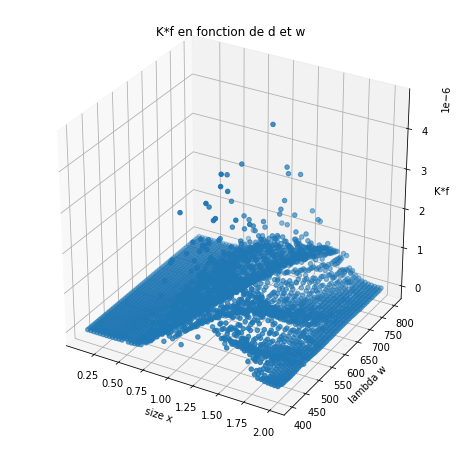

In [23]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca(projection = '3d') 
ax.scatter(value_d,value_w,L)
ax.set_xlabel("size x")
ax.set_ylabel("lambda w")
ax.set_zlabel("K*f")
ax.set_title("K*f en fonction de d et w")
plt.show()
